# 2D Flow Matching in JAX

This notebook implements flow matching on a 2D checkerboard dataset using an affine probability path $x_t = (1-t) \cdot x_0 + t \cdot x_1$ with $x_0 \sim \mathcal{N}(0, I)$. An MLP learns the velocity field $v_\theta(x, t)$ for ODE-based sampling and likelihood estimation via Hutchinson's trace estimator.

## Imports

In [9]:
import time
from collections.abc import Callable

import diffrax
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import random
from jaxtyping import Array, Float, PRNGKeyArray
from matplotlib import cm

## Dataset

In [10]:
@eqx.filter_jit
def generate_checkerboard_data(key: PRNGKeyArray, batch_size: int = 200) -> Float[Array, "batch_size 2"]:
    """Generate checkerboard dataset samples.

    Args:
        key: JAX random key for sampling.
        batch_size: Number of samples to generate.

    Returns:
        Array of 2D checkerboard pattern samples.
    """
    key1, key2, key3 = random.split(key, 3)

    x1 = random.uniform(key1, (batch_size,)) * 4 - 2
    x2_ = random.uniform(key2, (batch_size,)) - random.randint(key3, (batch_size,), 0, 2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = jnp.stack([x1, x2], axis=1) / 0.45
    return data.astype(jnp.float32)

## Probability path

In [11]:
class PathSample(eqx.Module):
    """Sample from probability path between x_0 and x_1.

    Attributes:
        x_t: Interpolated points along path at time t.
        dx_t: Velocity (time derivative) at points x_t.
        t: Time values corresponding to the samples.
    """

    x_t: Float[Array, "batch_size dim"]
    dx_t: Float[Array, "batch_size dim"]
    t: Float[Array, " batch_size"]


class AffineProbPath:
    r"""Affine probability path for flow matching.

    Implements linear interpolation path: $x_t = (1-t) \cdot x_0 + t \cdot x_1$
    """

    @eqx.filter_jit
    def sample(
        self, t: Float[Array, " batch_size"], x_0: Float[Array, "batch_size dim"], x_1: Float[Array, "batch_size dim"]
    ) -> PathSample:
        """Sample from linear path between x_0 and x_1.

        Args:
            t: Time values in [0, 1].
            x_0: Starting points (typically noise).
            x_1: Target points (data samples).

        Returns:
            PathSample containing interpolated points, velocities, and times.
        """
        t_expanded = t[:, None]
        x_t = (1 - t_expanded) * x_0 + t_expanded * x_1
        dx_t = x_1 - x_0
        return PathSample(x_t=x_t, dx_t=dx_t, t=t)

## Model

In [12]:
class MLP(eqx.Module):
    """Multi-layer perceptron for velocity field prediction.

    Attributes:
        mlp: Equinox MLP module for neural network computation.
    """

    mlp: eqx.nn.MLP

    def __init__(
        self, key: PRNGKeyArray, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128, depth: int = 5
    ) -> None:
        """Initialize MLP for velocity field prediction.

        Args:
            key: JAX random key for parameter initialization.
            input_dim: Dimensionality of input space.
            time_dim: Dimensionality of time encoding.
            hidden_dim: Width of hidden layers.
            depth: Number of hidden layers.
        """
        self.mlp = eqx.nn.MLP(
            in_size=input_dim + time_dim,
            out_size=input_dim,
            width_size=hidden_dim,
            depth=depth,
            activation=jax.nn.silu,
            key=key,
        )

    @eqx.filter_jit
    def __call__(
        self, x: Float[Array, "batch_size input_dim"], t: Float[Array, " batch_size"] | Float[Array, ""]
    ) -> Float[Array, "batch_size input_dim"]:
        """Forward pass through the MLP.

        Args:
            x: Input spatial coordinates.
            t: Time values.

        Returns:
            Predicted velocity field at (x, t).
        """
        batch_size = x.shape[0]
        t = jnp.broadcast_to(t, (batch_size,))
        h = jnp.column_stack([x, t])
        return jax.vmap(self.mlp)(h)

## Flow matching trainer and sampler

In [13]:
class FlowMatching:
    """Flow matching trainer with integrated sampling and likelihood computation."""

    def __init__(
        self,
        model: eqx.Module,
        learning_rate: float = 0.001,
        batch_size: int = 4096,
        step_size: float = 0.05,
        optimizer: optax.GradientTransformation | None = None,
        path: AffineProbPath | None = None,
        ode_solver: diffrax.AbstractSolver | None = None,
    ) -> None:
        """Initialize flow matching trainer.

        Args:
            model: Velocity field model to train.
            learning_rate: Learning rate for optimization.
            batch_size: Batch size for training.
            step_size: Initial step size for ODE solver.
            optimizer: Optax optimizer. Defaults to Adam with given learning rate.
            path: Probability path. Defaults to AffineProbPath.
            ode_solver: ODE solver for sampling and likelihood computation. Defaults to Dopri5.
        """
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.step_size = step_size
        self.optimizer = optimizer if optimizer is not None else optax.adamw(learning_rate)
        self.opt_state = self.optimizer.init(eqx.filter(model, eqx.is_array))
        self.path = path if path is not None else AffineProbPath()
        self.ode_solver = ode_solver if ode_solver is not None else diffrax.Dopri5()

    @staticmethod
    @eqx.filter_jit
    def _train_step(
        model: eqx.Module,
        optimizer: optax.GradientTransformation,
        opt_state: optax.OptState,
        batch_x0: Float[Array, "batch_size dim"],
        batch_x1: Float[Array, "batch_size dim"],
        batch_t: Float[Array, " batch_size"],
        path: AffineProbPath,
    ) -> tuple[eqx.Module, optax.OptState, float]:
        """Single training step for flow matching.

        Args:
            model: Velocity field model.
            optimizer: Optax optimizer.
            opt_state: Optimizer state.
            batch_x0: Batch of source points (noise).
            batch_x1: Batch of target points (data).
            batch_t: Batch of time values.
            path: Probability path object.

        Returns:
            Tuple of updated model, optimizer state, and loss value.
        """
        def loss_fn(model: eqx.Module) -> float:
            path_sample = path.sample(t=batch_t, x_0=batch_x0, x_1=batch_x1)
            predicted_velocity = model(path_sample.x_t, path_sample.t)
            loss = jnp.mean((predicted_velocity - path_sample.dx_t) ** 2)
            return loss

        loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss

    def train(
        self,
        data_generator: Callable[[PRNGKeyArray, int], Float[Array, "batch_size 2"]],
        key: PRNGKeyArray,
        iterations: int = 20001,
        print_every: int = 2000,
    ) -> PRNGKeyArray:
        """Train the flow matching model.

        Args:
            data_generator: Function that generates training data batches.
            key: JAX random key for sampling.
            iterations: Number of training iterations.
            print_every: Print loss every N iterations.
        """
        start_time = time.time()

        for i in range(iterations):
            key, data_key, noise_key, time_key = random.split(key, 4)

            x_1 = data_generator(data_key, self.batch_size)
            x_0 = random.normal(noise_key, x_1.shape)
            t = random.uniform(time_key, (self.batch_size,))

            self.model, self.opt_state, loss = self._train_step(
                self.model, self.optimizer, self.opt_state, x_0, x_1, t, self.path
            )

            if (i + 1) % print_every == 0:
                elapsed = time.time() - start_time
                print(f"| iter {i + 1:6d} | {elapsed * 1000 / print_every:5.2f} ms/step | loss {loss:8.3f}")
                start_time = time.time()

    @eqx.filter_jit
    def sample(
        self,
        time_grid: Float[Array, " time_steps"],
        x_init: Float[Array, "batch_size dim"],
        return_intermediates: bool = False,
    ) -> Float[Array, "time_steps batch_size dim"] | Float[Array, "batch_size dim"]:
        """Sample trajectories using diffrax ODE solver.

        Args:
            time_grid: Time points for integration.
            x_init: Initial conditions.
            return_intermediates: Whether to return trajectory at all time points.

        Returns:
            Final points or full trajectory depending on return_intermediates.
        """

        def vector_field(t: float, x: Float[Array, "batch_size dim"], args: tuple) -> Float[Array, "batch_size dim"]:
            (model,) = args
            return model(x, t)

        solution = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(vector_field),
            solver=self.ode_solver,
            t0=0.0,
            t1=1.0,
            dt0=self.step_size,
            y0=x_init,
            args=(self.model,),
            saveat=diffrax.SaveAt(ts=time_grid) if return_intermediates else diffrax.SaveAt(t1=True),
        )
        return solution.ys

    @staticmethod
    @eqx.filter_jit
    def _hutchinson_logp_wrapper(
        t: float, y: tuple[Float[Array, "batch_size dim"], Float[Array, " batch_size"]], args: tuple
    ) -> tuple[Float[Array, "batch_size dim"], Float[Array, " batch_size"]]:
        """Hutchinson's trace estimator wrapper for computing log-density change.

        Args:
            t: Current time.
            y: Tuple of (positions, log_density_change).
            args: Additional arguments including random vectors and velocity model.

        Returns:
            Tuple of (velocity_field, trace_estimate).
        """
        y, _ = y
        eps, velocity_model = args

        def fn(y_inner: Float[Array, "batch_size dim"]) -> Float[Array, "batch_size dim"]:
            return velocity_model(y_inner, t)

        f, vjp_fn = jax.vjp(fn, y)
        (eps_dfdy,) = vjp_fn(eps)
        logp = jnp.sum(eps_dfdy * eps, axis=1)
        return f, logp

    @eqx.filter_jit
    def compute_log_likelihood(
        self, x_data: Float[Array, "batch_size dim"], key: PRNGKeyArray
    ) -> Float[Array, " batch_size"]:
        """Compute log-likelihood using Hutchinson's estimator.

        Args:
            x_data: Data points to evaluate likelihood at.
            key: Random key for Hutchinson estimator.

        Returns:
            Log-likelihood estimates for each data point.
        """
        batch_size = x_data.shape[0]

        eps = random.rademacher(key, x_data.shape, dtype=x_data.dtype)
        delta_log_likelihood = jnp.zeros(batch_size)

        solution = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(self._hutchinson_logp_wrapper),
            solver=self.ode_solver,
            t0=1.0,
            t1=0.0,
            dt0=-self.step_size,
            y0=(x_data, delta_log_likelihood),
            args=(eps, self.model),
        )

        final_x, final_delta_log_p = solution.ys
        final_x = jnp.squeeze(final_x, axis=0)
        final_delta_log_p = jnp.squeeze(final_delta_log_p, axis=0)

        base_log_p = -0.5 * (final_x.shape[1] * jnp.log(2 * jnp.pi) + jnp.sum(final_x**2, axis=1))

        return final_delta_log_p + base_log_p

## Train flow matching model

In [14]:
def train_flow_matching_model() -> FlowMatching:
    """Train a 2D flow matching model on checkerboard data.

    Returns:
        Trained FlowMatching instance.
    """
    key = random.key(42)
    train_key, model_key = random.split(key)

    model = MLP(model_key, input_dim=2, time_dim=1, hidden_dim=512)
    flow_matcher = FlowMatching(
        model=model,
        learning_rate=0.001,
        batch_size=4096,
        step_size=0.05
    )

    flow_matcher.train(
        data_generator=generate_checkerboard_data,
        key=train_key,
        iterations=20001,
        print_every=2000,
    )

    return flow_matcher

model = train_flow_matching_model()

| iter   2000 |  3.85 ms/step | loss    3.870
| iter   4000 |  2.76 ms/step | loss    3.651
| iter   6000 |  2.69 ms/step | loss    3.746
| iter   8000 |  2.80 ms/step | loss    3.680
| iter  10000 |  2.80 ms/step | loss    3.923
| iter  12000 |  2.83 ms/step | loss    3.747
| iter  14000 |  2.84 ms/step | loss    3.847
| iter  16000 |  2.80 ms/step | loss    3.847
| iter  18000 |  2.82 ms/step | loss    3.737
| iter  20000 |  2.78 ms/step | loss    3.821


## Visualizing flow path

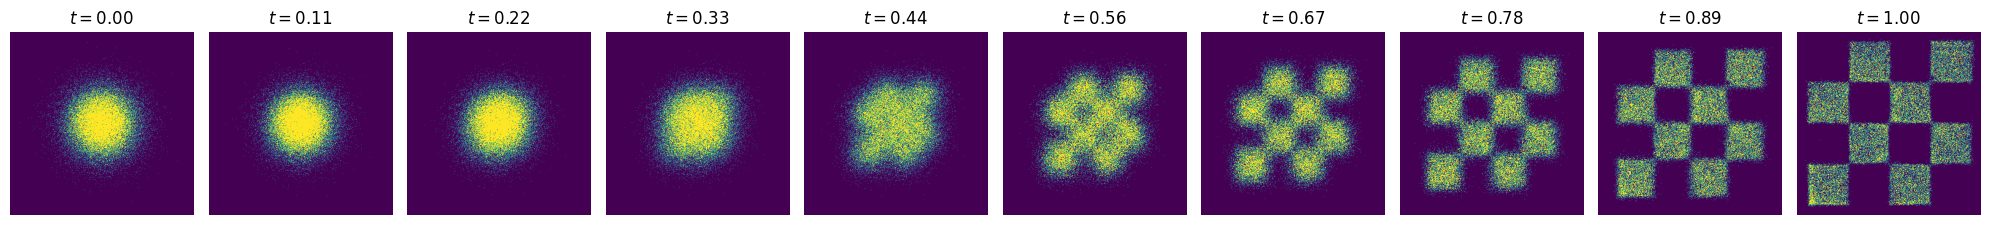

In [15]:
def visualize_flow_path(flow_matcher: FlowMatching, batch_size: int = 50000) -> None:
    """Visualize the flow path evolution over time.

    Args:
        flow_matcher: Trained FlowMatching instance.
        batch_size: Number of trajectories to simulate.
    """
    sample_key = random.key(42)
    x_init = random.normal(sample_key, (batch_size, 2))
    T = jnp.linspace(0, 1, 10)

    trajectory = flow_matcher.sample(time_grid=T, x_init=x_init, return_intermediates=True)

    trajectory_np = np.array(trajectory)
    T_np = np.array(T)

    _, axs = plt.subplots(1, 10, figsize=(20, 4))
    axs = axs.flatten()

    for i in range(10):
        H, _, _ = np.histogram2d(trajectory_np[i, :, 0], trajectory_np[i, :, 1], bins=300, range=[[-5, 5], [-5, 5]])
        cmax = np.quantile(H, 0.95)
        norm = cm.colors.Normalize(vmax=cmax, vmin=0)

        axs[i].imshow(H.T, extent=[-5, 5, -5, 5], origin="lower", cmap="viridis", norm=norm)
        axs[i].set_aspect("equal")
        axs[i].axis("off")
        axs[i].set_title(f"$t = {T_np[i]:.2f}$")
        axs[i].set_xlabel("$x_1$")
        axs[i].set_ylabel("$x_2$")

    plt.tight_layout()
    plt.show()

visualize_flow_path(model)

## Visualizing learned likelihood

Computing likelihood with 10 Hutchinson estimates...
Accumulation step 1/10


Accumulation step 2/10
Accumulation step 3/10
Accumulation step 4/10
Accumulation step 5/10
Accumulation step 6/10
Accumulation step 7/10
Accumulation step 8/10
Accumulation step 9/10
Accumulation step 10/10
Likelihood computation completed in 9.24 seconds


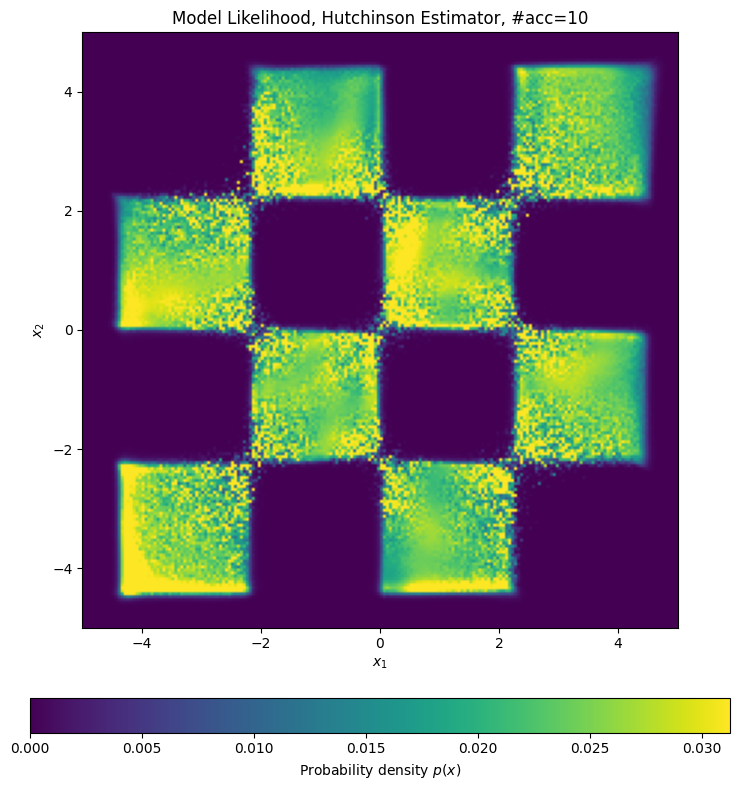

In [16]:
def visualize_likelihood(flow_matcher: FlowMatching, grid_size: int = 200, num_acc: int = 10) -> None:
    """Visualize the learned likelihood using averaged Hutchinson estimator.

    Args:
        flow_matcher: Trained FlowMatching instance.
        grid_size: Resolution of evaluation grid.
        num_acc: Number of Hutchinson estimates to average.
    """
    key = random.key(42)

    x_range = jnp.linspace(-5, 5, grid_size)
    y_range = jnp.linspace(-5, 5, grid_size)
    X, Y = jnp.meshgrid(x_range, y_range)
    grid_points = jnp.stack([X.flatten(), Y.flatten()], axis=1)

    print(f"Computing likelihood with {num_acc} Hutchinson estimates...")
    start_time = time.time()

    log_p_acc = jnp.zeros(len(grid_points))

    for acc_step in range(num_acc):
        print(f"Accumulation step {acc_step + 1}/{num_acc}")

        key, step_key = random.split(key)
        batch_log_p = flow_matcher.compute_log_likelihood(grid_points, step_key)
        log_p_acc += batch_log_p

    log_p_acc /= num_acc

    elapsed = time.time() - start_time
    print(f"Likelihood computation completed in {elapsed:.2f} seconds")

    likelihood = jnp.exp(log_p_acc).reshape(grid_size, grid_size)
    likelihood_np = np.array(likelihood)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    cmin = 0.0
    cmax = 1 / 32
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    im = ax.imshow(likelihood_np, extent=(-5, 5, -5, 5), origin="lower", cmap="viridis", norm=norm)
    ax.set_title(f"Model Likelihood, Hutchinson Estimator, #acc={num_acc}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    fig.colorbar(im, ax=ax, orientation="horizontal", label="Probability density $p(x)$", fraction=0.05, pad=0.1)

    plt.tight_layout()
    plt.show()

visualize_likelihood(model)